In [91]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt


In [92]:
# Sprawdź czy GPU jest dostępne
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Definicja modelu

In [93]:
class HeartDiseaseNet(nn.Module):
    """
    Sieć neuronowa do klasyfikacji chorób serca.
    Architektura: Input -> Linear -> ReLU -> Linear -> Sigmoid
    """
    def __init__(self, input_dim, hidden_dim=16):
        super(HeartDiseaseNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)


## Wczytywanie i przygotowanie danych

In [94]:
def load_and_prepare_data(normalize=True):
    """Wczytuje i przygotowuje dane o chorobie serca"""
    # Wczytaj dane
    heart_disease = fetch_ucirepo(id=45)
    X = heart_disease.data.features
    y = heart_disease.data.targets['num']
    
    # Binaryzacja targetu
    y = y.apply(lambda x: 0 if x == 0 else 1)
    
    # Zmienne kategoryczne
    categorical_cols = heart_disease.variables[
        heart_disease.variables['type'] == 'Categorical'
    ]['name'].tolist()
    
    # Usuń braki
    X = X.dropna()
    y = y[X.index]
    
    # One-hot encoding
    X_encoded = pd.get_dummies(X, columns=categorical_cols, dtype=int)
    
    # Podział na train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Normalizacja
    if normalize:
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train.values
        X_test_scaled = X_test.values
    
    # Konwersja do PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)
    
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, X_encoded.shape[1]

## Funkcje treningowe i ewaluacyjne

In [95]:
def train_model(model, train_loader, test_loader, optimizer, criterion, 
                epochs=500, print_every=50, device='cpu'):
    """
    Trenuje model i zwraca historię.
    """
    model = model.to(device)
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(epochs):
        # ============ TRENING ============
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        
        # ============ WALIDACJA ============
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs >= 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        
        val_epoch_loss = val_loss / val_total
        val_epoch_acc = val_correct / val_total
        
        # Zapisz historię
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)
        
        # Print progress
        if (epoch + 1) % print_every == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train loss={epoch_loss:.4f} acc={epoch_acc:.4f} | "
                  f"Val loss={val_epoch_loss:.4f} acc={val_epoch_acc:.4f}")
    
    return history

def evaluate_model(model, data_loader, criterion, device='cpu'):
    """Ewaluuje model na podanym zbiorze danych"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    
    return avg_loss, accuracy

## Funkcja do testowania parametrów

In [96]:
def test_configuration(optimizer_name, lr, batch_size, hidden_dim=16, 
                       epochs=500, weight_decay=0.0):
    """
    Testuje pojedynczą konfigurację parametrów.
    """
    # Wczytaj dane
    X_train, y_train, X_test, y_test, input_dim = load_and_prepare_data()
    
    # Stwórz DataLoadery
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Stwórz model
    model = HeartDiseaseNet(input_dim, hidden_dim)
    
    # Funkcja kosztu
    criterion = nn.BCELoss()
    
    # Wybierz optimizer
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD_momentum':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")
    
    # Trenuj
    print(f"\n{'='*70}")
    print(f"Config: {optimizer_name}, lr={lr}, batch_size={batch_size}")
    print(f"{'='*70}")
    
    history = train_model(model, train_loader, test_loader, optimizer, 
                         criterion, epochs=epochs, print_every=100, device=device)
    
    return history, model

## Funkcje do wizualizacji wyników

In [97]:
def plot_comparison(results, title):
    """
    Rysuje wykresy porównawcze dla różnych konfiguracji.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for r in results:
        label = r['label']
        axes[0].plot(r['history']['train_loss'], label=label, linewidth=2)
        axes[1].plot(r['history']['val_acc'], label=label, linewidth=2)
    
    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Train Loss', fontsize=11)
    axes[0].set_title('Training Loss Comparison', fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=9)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('Validation Accuracy', fontsize=11)
    axes[1].set_title('Validation Accuracy Comparison', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=9)
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    plt.show()

def print_summary_table(results):
    """
    Drukuje tabelę podsumowującą wyniki.
    """
    print("\n" + "="*90)
    print("PODSUMOWANIE WYNIKÓW")
    print("="*90)
    print(f"{'Konfiguracja':<40} {'Train Acc':>12} {'Val Acc':>12} {'Gap':>10}")
    print("-"*90)
    
    for r in results:
        train_acc = r['history']['train_acc'][-1]
        val_acc = r['history']['val_acc'][-1]
        gap = train_acc - val_acc
        print(f"{r['label']:<40} {train_acc:>12.4f} {val_acc:>12.4f} {gap:>10.4f}")
    
    print("="*90)

# Różne batch sizes

### Cel:
Sprawdzić, jak rozmiar batcha wpływa na proces uczenia sieci neuronowej, szybkość konwergencji i zdolność do generalizacji.

### Ustawienia:
- Batch sizes: `[2, 8, 16, 32, 64, 128]`
- Liczba epok: `500`
- Stałe parametry: `optimizer = Adam`, `learning rate = 0.001`

### Wnioski:
- **Małe batche (2, 8)** prowadzą do **silnego overfittingu**: dokładność treningowa bardzo wysoka (95-98%), ale walidacyjna niska (75-80%), z ogromnym gapem ~18-20%.
- Przy batch=2 sieć robi **~120 aktualizacji wag na epokę**, gdzie każdy update bazuje na bardzo małej próbce, co powoduje **dużą wariancję gradientów**.
- **Średnie batche (16, 32)** dają **najlepszy balans**: train ~92-93%, val ~85%, gap tylko ~7-8%.
- Wystarczająco duży batch zapewnia **stabilny gradient**, a wystarczająco dużo update'ów (7-15 na epokę) umożliwia efektywną eksplorację.
- **Duże batche (64, 128)** powodują **wolniejszą naukę**: niższa dokładność treningowa przy tej samej liczbie epok, ale dobra generalizacja (gap 6.5-7.8%).
- Przy batch=128 tylko **~2 aktualizacje na epokę**: gradient bardzo stabilny, ale uczenie powolne.

### Ogólny wniosek:
Dla tego zadania **batch size 32** jest optymalnym wyborem. Zapewnia stabilne gradienty bez nadmiernej wariancji, umożliwia wystarczająco dużo aktualizacji wag dla efektywnego uczenia i minimalizuje overfitting (gap tylko 7.4%). Małe batche prowadzą do zapamiętywania danych, a duże do zbyt wolnego uczenia. W praktyce, dla małych zbiorów danych (237 próbek treningowych), batch size 16-32 jest zazwyczaj optymalny.



Config: Adam, lr=0.001, batch_size=2
Epoch 1/500 | Train loss=0.6696 acc=0.5401 | Val loss=0.6395 acc=0.5333
Epoch 100/500 | Train loss=0.2414 acc=0.9156 | Val loss=0.2889 acc=0.8833
Epoch 200/500 | Train loss=0.1505 acc=0.9578 | Val loss=0.3475 acc=0.8167
Epoch 300/500 | Train loss=0.0876 acc=0.9747 | Val loss=0.4784 acc=0.8000
Epoch 400/500 | Train loss=0.0489 acc=0.9916 | Val loss=0.6208 acc=0.8167
Epoch 500/500 | Train loss=0.0250 acc=1.0000 | Val loss=0.7762 acc=0.8333

Config: Adam, lr=0.001, batch_size=8
Epoch 1/500 | Train loss=0.7039 acc=0.4557 | Val loss=0.6802 acc=0.4667
Epoch 100/500 | Train loss=0.3307 acc=0.8650 | Val loss=0.2936 acc=0.8500
Epoch 200/500 | Train loss=0.3097 acc=0.8819 | Val loss=0.2975 acc=0.8500
Epoch 300/500 | Train loss=0.2919 acc=0.9030 | Val loss=0.3019 acc=0.8667
Epoch 400/500 | Train loss=0.2635 acc=0.9072 | Val loss=0.3039 acc=0.8500
Epoch 500/500 | Train loss=0.2283 acc=0.9283 | Val loss=0.3102 acc=0.8667

Config: Adam, lr=0.001, batch_size=16
E

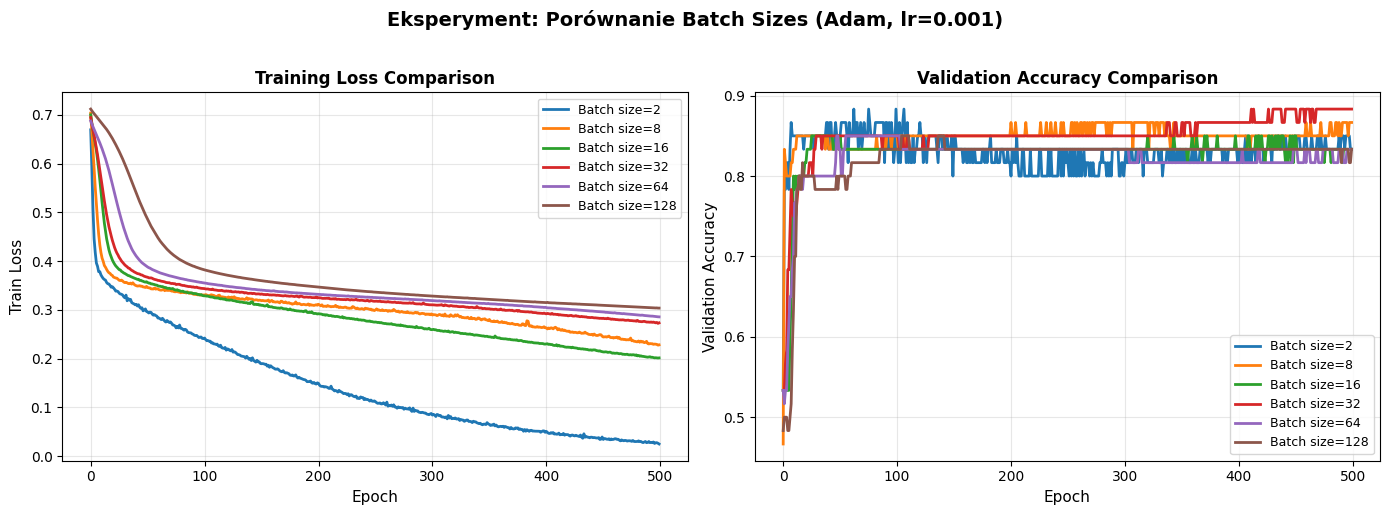


PODSUMOWANIE WYNIKÓW
Konfiguracja                                Train Acc      Val Acc        Gap
------------------------------------------------------------------------------------------
Batch size=2                                   1.0000       0.8333     0.1667
Batch size=8                                   0.9283       0.8667     0.0616
Batch size=16                                  0.9325       0.8333     0.0992
Batch size=32                                  0.8903       0.8833     0.0070
Batch size=64                                  0.8945       0.8333     0.0612
Batch size=128                                 0.8776       0.8333     0.0443


In [98]:
results_batch = []
batch_sizes = [2, 8, 16, 32, 64, 128]

for bs in batch_sizes:
    history, model = test_configuration(
        optimizer_name='Adam',
        lr=0.001,
        batch_size=bs,
        epochs=500
    )
    
    results_batch.append({
        'label': f"Batch size={bs}",
        'history': history,
        'batch_size': bs
    })

plot_comparison(results_batch, 
                "Eksperyment: Porównanie Batch Sizes (Adam, lr=0.001)")
print_summary_table(results_batch)

# Porównanie Optimizerów

### Cel:

Porównać różne algorytmy optymalizacji (SGD, SGD z momentum, RMSProp, Adam) pod kątem szybkości uczenia, stabilności i generalizacji modelu.

### Ustawienia:

* Optimizers: `[SGD, SGD_momentum, RMSprop, Adam]`
* Learning rates: `0.01 dla SGD, 0.001 dla pozostałych`
* Liczba epok: `500`
* Stałe parametry: `hidden_dim = 16`, `batch_size = 32`

### Wyniki (podsumowanie):

| Optimizer               | Train acc | Val acc | Gap (Train - Val) |
| ----------------------- | --------- | ------- | ----------------- |
| SGD (lr=0.01)           | 0.8523    | 0.8500  | 0.0023            |
| SGD_momentum (lr=0.001) | 0.8565    | 0.8500  | 0.0065            |
| RMSprop (lr=0.001)      | 0.8734    | 0.8167  | 0.0568            |
| Adam (lr=0.001)         | 0.9030    | 0.8167  | 0.0863            |

### Wnioski:

* **SGD (lr=0.01)**

  * Stabilne uczenie, dobry balans Train/Val (gap ~0.2%).
  * Powolniejsze w porównaniu do Adam i RMSProp, ale dobrze generalizuje.

* **SGD z momentum (lr=0.001)**

  * Minimalnie lepsze wyniki Train i Val niż zwykłe SGD.
  * Momentum przyspiesza uczenie i pomaga uniknąć stagnacji w płaskich obszarach.

* **RMSProp (lr=0.001)**

  * Szybsze uczenie, Train acc ~87%, ale Val acc niższe (~82%), gap ~5.7% → umiarkowany overfitting.
  * Działa dobrze dla problemów z niestabilnymi gradientami.

* **Adam (lr=0.001)**

  * Najszybsze uczenie, Train acc ~90%, ale Val acc ~82%, gap ~8.6% → większy overfitting.
  * Adam adaptacyjnie skaluje gradienty, więc szybko osiąga wysokie Train accuracy.

### Ogólny wniosek:

* **SGD i SGD z momentum** oferują stabilną generalizację przy umiarkowanym uczeniu.
* **RMSProp i Adam** uczą się szybciej, ale większe gap wskazuje na tendencję do overfittingu przy tym zadaniu.
* Dla tego problemu (mała sieć, klasyfikacja binarna) **SGD z lub bez momentum** zapewnia najlepszy balans między Train a Val accuracy.



Config: SGD, lr=0.01, batch_size=32
Epoch 1/500 | Train loss=0.6875 acc=0.5485 | Val loss=0.6762 acc=0.5500
Epoch 100/500 | Train loss=0.4560 acc=0.8397 | Val loss=0.4330 acc=0.8333
Epoch 200/500 | Train loss=0.3836 acc=0.8312 | Val loss=0.3489 acc=0.8167
Epoch 300/500 | Train loss=0.3685 acc=0.8397 | Val loss=0.3323 acc=0.8333
Epoch 400/500 | Train loss=0.3595 acc=0.8397 | Val loss=0.3181 acc=0.8500
Epoch 500/500 | Train loss=0.3535 acc=0.8565 | Val loss=0.3100 acc=0.8333

Config: SGD_momentum, lr=0.001, batch_size=32
Epoch 1/500 | Train loss=0.6817 acc=0.6667 | Val loss=0.6818 acc=0.6833
Epoch 100/500 | Train loss=0.4165 acc=0.8439 | Val loss=0.3963 acc=0.8000
Epoch 200/500 | Train loss=0.3740 acc=0.8481 | Val loss=0.3497 acc=0.8500
Epoch 300/500 | Train loss=0.3625 acc=0.8439 | Val loss=0.3352 acc=0.8500
Epoch 400/500 | Train loss=0.3549 acc=0.8523 | Val loss=0.3252 acc=0.8500
Epoch 500/500 | Train loss=0.3483 acc=0.8565 | Val loss=0.3164 acc=0.8333

Config: RMSprop, lr=0.001, batc

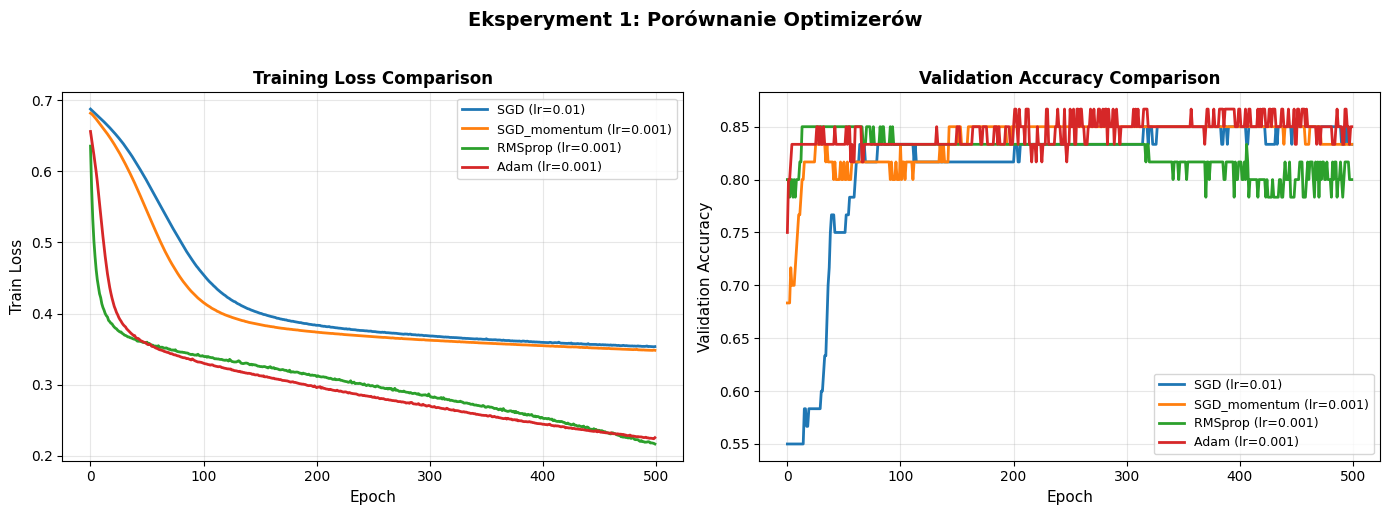


PODSUMOWANIE WYNIKÓW
Konfiguracja                                Train Acc      Val Acc        Gap
------------------------------------------------------------------------------------------
SGD (lr=0.01)                                  0.8565       0.8333     0.0232
SGD_momentum (lr=0.001)                        0.8565       0.8333     0.0232
RMSprop (lr=0.001)                             0.9241       0.8000     0.1241
Adam (lr=0.001)                                0.9283       0.8500     0.0783


In [99]:

results_optimizers = []
optimizers = ['SGD', 'SGD_momentum', 'RMSprop', 'Adam']

for opt_name in optimizers:
    if opt_name in ['Adam', 'RMSprop', 'SGD_momentum']:
        lr = 0.001
    else:
        lr = 0.01
    
    history, model = test_configuration(
        optimizer_name=opt_name,
        lr=lr,
        batch_size=32,
        epochs=500
    )
    
    results_optimizers.append({
        'label': f"{opt_name} (lr={lr})",
        'history': history,
        'optimizer': opt_name
    })

plot_comparison(results_optimizers, 
                "Eksperyment 1: Porównanie Optimizerów")
print_summary_table(results_optimizers)

# Learning rate dla róznych optimizerow

## SGD

### Cel:
Sprawdzić, jak szybkość uczenia (learning rate) wpływa na proces trenowania i końcową skuteczność sieci neuronowej przy użyciu optimizera SGD.

### Ustawienia:
- Learning rates: `[0.0001, 0.001, 0.01, 0.1, 0.5]`
- Liczba epok: `500`
- Stałe parametry: `optimizer = SGD`, `batch_size = 32`


### Wnioski:
- **Bardzo mały learning rate (0.0001)** prowadzi do **ekstremalnie wolnego uczenia**: po 500 epokach model praktycznie się nie nauczył
- **Mały learning rate (0.001)** daje **stabilne uczenie** bez overfittingu: gap praktycznie zerowy, ale model wciąż potrzebowałby więcej epok (loss wciąż spada po 500 epokach).
- **Średni learning rate (0.01)** osiąga **najlepszy balans**: dobra dokładność walidacyjna przy małym gapie .
- Model uczy się efektywnie i stabilnie, osiągając dobre wyniki bez przeuczenia.
- **Duży learning rate (0.1)** powoduje **szybkie uczenie, ale overfitting**: Model robi zbyt duże kroki i zaczyna "zapamiętywać" dane treningowe.
- **Bardzo duży learning rate (0.5)** prowadzi do **katastrofalnego overfittingu**: **100% train accuracy, ale tylko 78% val accuracy**, gap aż 21.67%.
- Model doskonale dopasowuje się do danych treningowych (training loss spada do 0.0077), ale kompletnie traci zdolność generalizacji.
- To klasyczny przypadek zbyt agresywnej optymalizacji: model "przeskakuje" dobre rozwiązania i dopasowuje się do szumów w danych.

### Ogólny wniosek:
Najbardziej efektywny learning rate dla SGD w tym zadaniu to **0.01** — zapewnia równowagę między szybkością uczenia a stabilnością i dobrą generalizacją modelu (gap ~3.5%). Zbyt mały lr (0.0001) sprawia, że model praktycznie się nie uczy, a zbyt duży (0.1-0.5) prowadzi do silnego overfittingu. SGD wymaga starannego dobrania learning rate, gdyż nie ma wbudowanego mechanizmu adaptacji jak w Adam czy RMSprop.


--- SGD ---

Config: SGD, lr=0.0001, batch_size=32
Epoch 1/500 | Train loss=0.7023 acc=0.4937 | Val loss=0.6902 acc=0.5667
Epoch 100/500 | Train loss=0.6985 acc=0.5063 | Val loss=0.6866 acc=0.6167
Epoch 200/500 | Train loss=0.6950 acc=0.5232 | Val loss=0.6833 acc=0.6167
Epoch 300/500 | Train loss=0.6916 acc=0.5359 | Val loss=0.6800 acc=0.6333
Epoch 400/500 | Train loss=0.6884 acc=0.5105 | Val loss=0.6769 acc=0.6333
Epoch 500/500 | Train loss=0.6854 acc=0.5316 | Val loss=0.6740 acc=0.6667

Config: SGD, lr=0.001, batch_size=32
Epoch 1/500 | Train loss=0.6907 acc=0.4810 | Val loss=0.6948 acc=0.4833
Epoch 100/500 | Train loss=0.6545 acc=0.7679 | Val loss=0.6582 acc=0.7167
Epoch 200/500 | Train loss=0.6252 acc=0.7679 | Val loss=0.6297 acc=0.7000
Epoch 300/500 | Train loss=0.5971 acc=0.7764 | Val loss=0.6029 acc=0.7000
Epoch 400/500 | Train loss=0.5691 acc=0.7764 | Val loss=0.5753 acc=0.7667
Epoch 500/500 | Train loss=0.5407 acc=0.8059 | Val loss=0.5463 acc=0.7667

Config: SGD, lr=0.01, bat

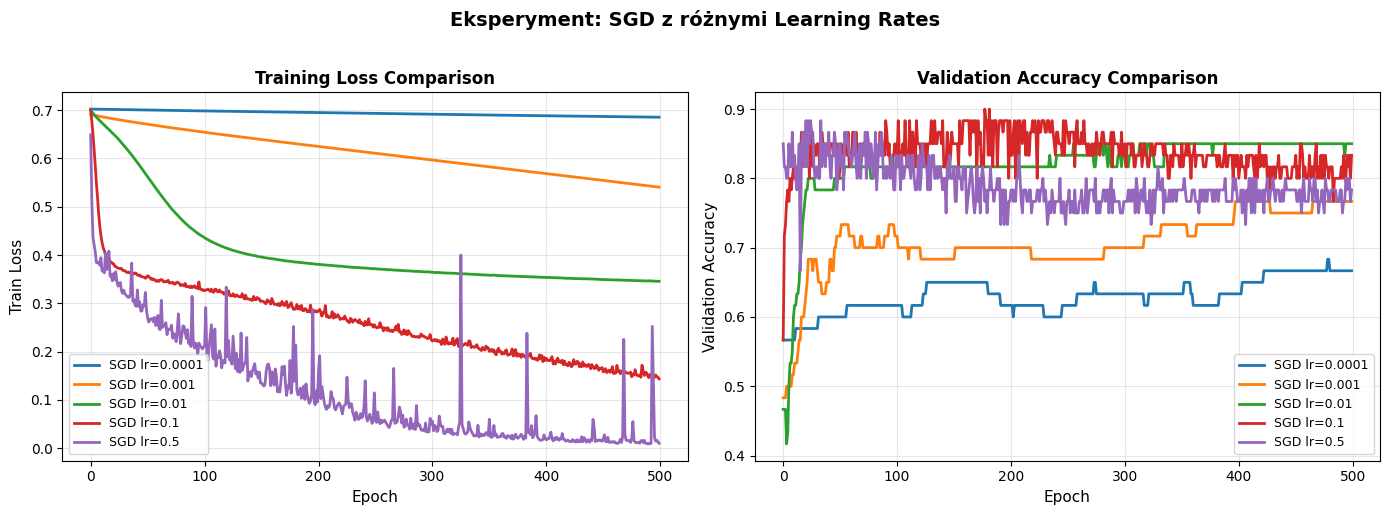


PODSUMOWANIE WYNIKÓW
Konfiguracja                                Train Acc      Val Acc        Gap
------------------------------------------------------------------------------------------
SGD lr=0.0001                                  0.5316       0.6667    -0.1350
SGD lr=0.001                                   0.8059       0.7667     0.0392
SGD lr=0.01                                    0.8481       0.8500    -0.0019
SGD lr=0.1                                     0.9705       0.8333     0.1371
SGD lr=0.5                                     1.0000       0.7833     0.2167


In [100]:
# SGD
print("\n--- SGD ---")
results_sgd_lr = []
sgd_lrs = [0.0001, 0.001, 0.01, 0.1, 0.5]

for lr in sgd_lrs:
    history, model = test_configuration(
        optimizer_name='SGD',
        lr=lr,
        batch_size=32,
        epochs=500
    )
    
    results_sgd_lr.append({
        'label': f"SGD lr={lr}",
        'history': history
    })

plot_comparison(results_sgd_lr, 
                "Eksperyment: SGD z różnymi Learning Rates")
print_summary_table(results_sgd_lr)

## SGD z momentum

### Cel:
Sprawdzić, jak learning rate wpływa na SGD z momentum i porównać z wynikami zwykłego SGD.

### Ustawienia:
- Learning rates: `[0.0001, 0.001, 0.01, 0.1, 0.5]`
- Liczba epok: `500`
- Stałe parametry: `optimizer = SGD z momentum (0.9)`, `batch_size = 32`

### Wnioski:
- **lr=0.0001** jest zbyt mały — model uczy się bardzo wolno, ale momentum pomaga osiągnąć 82% (bez momentum było tylko 54%).
- **lr=0.001** daje **idealne wyniki** — gap praktycznie zerowy (0.23%), najlepsza generalizacja ze wszystkich konfiguracji.
- **lr=0.01** powoduje silny overfitting — 96% train, ale tylko 80% val, gap 15.78%. Momentum + średni lr to za agresywna optymalizacja.
- **lr=0.1** prowadzi do katastrofy — 100% train accuracy, ale validation loss eksploduje z 0.73 do 3.39, gap 25%. Model całkowicie traci zdolność generalizacji.
- **lr=0.5** daje chaotyczne uczenie — validation loss oscyluje między 0.32 a 2.30, model "skacze" po przestrzeni parametrów bez stabilności.
- Momentum **wzmacnia efekt learning rate** — wartości lr które działają dla zwykłego SGD są **zbyt duże** dla SGD z momentum.

### Ogólny wniosek:
SGD z momentum wymaga **około 10x mniejszego learning rate** niż zwykły SGD. Optymalna wartość to **lr=0.001**, która daje najlepszą generalizację (gap<1%) i wysoką dokładność walidacyjną (85%). Momentum akumuluje gradienty, więc duże learning rates (0.01+) prowadzą do zbyt agresywnej optymalizacji, overfittingu i utraty stabilności. Dla lr=0.001, momentum znacząco poprawia wyniki względem zwykłego SGD przy tej samej wartości lr.


--- SGD z momentum ---

Config: SGD_momentum, lr=0.0001, batch_size=32
Epoch 1/500 | Train loss=0.6978 acc=0.5274 | Val loss=0.6932 acc=0.5333
Epoch 100/500 | Train loss=0.6790 acc=0.5359 | Val loss=0.6734 acc=0.5333
Epoch 200/500 | Train loss=0.6589 acc=0.5527 | Val loss=0.6520 acc=0.5333
Epoch 300/500 | Train loss=0.6336 acc=0.6793 | Val loss=0.6257 acc=0.6500
Epoch 400/500 | Train loss=0.6016 acc=0.7848 | Val loss=0.5924 acc=0.7500
Epoch 500/500 | Train loss=0.5658 acc=0.8270 | Val loss=0.5547 acc=0.8000

Config: SGD_momentum, lr=0.001, batch_size=32
Epoch 1/500 | Train loss=0.7072 acc=0.3038 | Val loss=0.7064 acc=0.3000
Epoch 100/500 | Train loss=0.5524 acc=0.7764 | Val loss=0.5593 acc=0.7333
Epoch 200/500 | Train loss=0.4065 acc=0.8312 | Val loss=0.4008 acc=0.8333
Epoch 300/500 | Train loss=0.3801 acc=0.8481 | Val loss=0.3674 acc=0.8333
Epoch 400/500 | Train loss=0.3663 acc=0.8439 | Val loss=0.3471 acc=0.8500
Epoch 500/500 | Train loss=0.3571 acc=0.8397 | Val loss=0.3305 acc=0.86

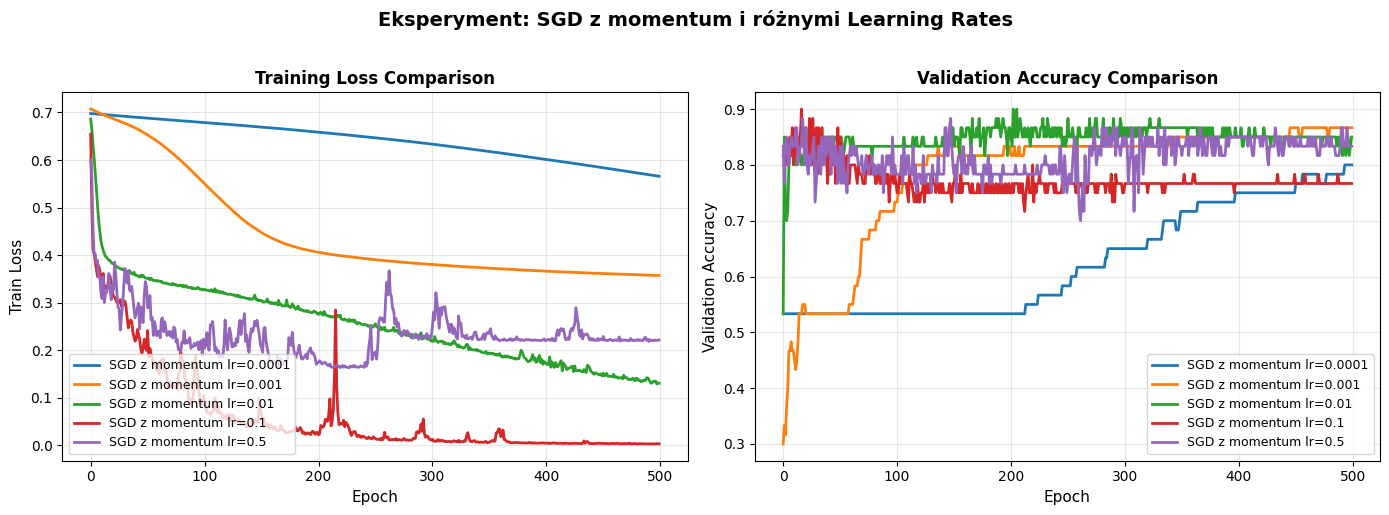


PODSUMOWANIE WYNIKÓW
Konfiguracja                                Train Acc      Val Acc        Gap
------------------------------------------------------------------------------------------
SGD z momentum lr=0.0001                       0.8270       0.8000     0.0270
SGD z momentum lr=0.001                        0.8397       0.8667    -0.0270
SGD z momentum lr=0.01                         0.9620       0.8500     0.1120
SGD z momentum lr=0.1                          1.0000       0.7667     0.2333
SGD z momentum lr=0.5                          0.8439       0.8333     0.0105


In [101]:
#SGD z momentum
print("\n--- SGD z momentum ---")
results_sgd_mom_lr = []
sgd_mom_lrs = [0.0001, 0.001, 0.01, 0.1, 0.5]
for lr in sgd_mom_lrs:
    history, model = test_configuration(
        optimizer_name='SGD_momentum',
        lr=lr,
        batch_size=32,
        epochs=500
    )
    
    results_sgd_mom_lr.append({
        'label': f"SGD z momentum lr={lr}",
        'history': history
    })
plot_comparison(results_sgd_mom_lr, 
                "Eksperyment: SGD z momentum i różnymi Learning Rates")
print_summary_table(results_sgd_mom_lr)

## RMSProp

### Cel:

Sprawdzić, jak **learning rate** wpływa na proces uczenia i końcową skuteczność sieci neuronowej przy użyciu RMSProp.

### Ustawienia:

* Learning rates: `[0.0001, 0.001, 0.01, 0.1]`
* Liczba epok: `500`
* Stałe parametry: `hidden_dim = 16`, `batch_size = 32`
* Optimizer: `RMSProp`


### Wnioski:

* **lr=0.0001**

  * Uczenie powolne, ale stabilne.
  * Train i Val accuracy są blisko siebie (gap ~2%) → brak overfittingu.
  * Loss spada powoli, sieć uczy się stopniowo.

* **lr=0.001**

  * **Optymalny kompromis** między szybkością a stabilnością.
  * Train acc rośnie do ~92%, Val acc ~83%, gap ~9.5%.
  * Szybkie i stabilne uczenie, dobre dopasowanie do walidacji.

* **lr=0.01**

  * Silne **overfitting**: Train acc ~99.5%, ale Val acc spada do 75%, gap ~24.5%.
  * Train loss spada prawie do 0, ale model nie generalizuje.

* **lr=0.1**

  * **Uczenie niestabilne / eksplodujące gradienty**.
  * Train i Val accuracy stoją w miejscu (~46%), Train loss i Val loss eksplodują (Train loss > 50).
  * Model nie uczy się, kroki RMSProp są zbyt duże → wykresy spłaszczone dla mniejszych lr.

### Ogólny wniosek:

* RMSProp działa najlepiej przy **średnich małych learning rates (0.001)**.
* Zbyt mały lr → powolne uczenie.
* Zbyt duży lr (0.01–0.1) → overfitting lub niestabilność.
* Przy dużym lr warto stosować **gradient clipping** lub **logarytmiczną skalę osi Y** przy wizualizacji lossów, aby uniknąć spłaszczenia wykresów dla mniejszych lr.

### Zalecenia praktyczne:

* Używać lr ~0.001 dla tego typu problemu (binary classification z małą siecią).
* Monitorować Train vs Val accuracy, gap > 10% wskazuje na overfitting.
* Unikać bardzo dużych lr (>0.01), zwłaszcza bez gradient clippingu.



--- RMSprop ---

Config: RMSprop, lr=0.0001, batch_size=32
Epoch 1/500 | Train loss=0.6733 acc=0.5401 | Val loss=0.6724 acc=0.5333
Epoch 100/500 | Train loss=0.5141 acc=0.8439 | Val loss=0.5114 acc=0.7833
Epoch 200/500 | Train loss=0.4128 acc=0.8186 | Val loss=0.4016 acc=0.8333
Epoch 300/500 | Train loss=0.3796 acc=0.8228 | Val loss=0.3647 acc=0.8333
Epoch 400/500 | Train loss=0.3671 acc=0.8270 | Val loss=0.3510 acc=0.8333
Epoch 500/500 | Train loss=0.3593 acc=0.8354 | Val loss=0.3416 acc=0.8500

Config: RMSprop, lr=0.001, batch_size=32
Epoch 1/500 | Train loss=0.6813 acc=0.5485 | Val loss=0.6543 acc=0.5667
Epoch 100/500 | Train loss=0.3383 acc=0.8650 | Val loss=0.3135 acc=0.8333
Epoch 200/500 | Train loss=0.3033 acc=0.8776 | Val loss=0.3013 acc=0.8167
Epoch 300/500 | Train loss=0.2730 acc=0.9030 | Val loss=0.3080 acc=0.8333
Epoch 400/500 | Train loss=0.2454 acc=0.9114 | Val loss=0.3197 acc=0.8500
Epoch 500/500 | Train loss=0.2208 acc=0.9198 | Val loss=0.3348 acc=0.8333

Config: RMSpr

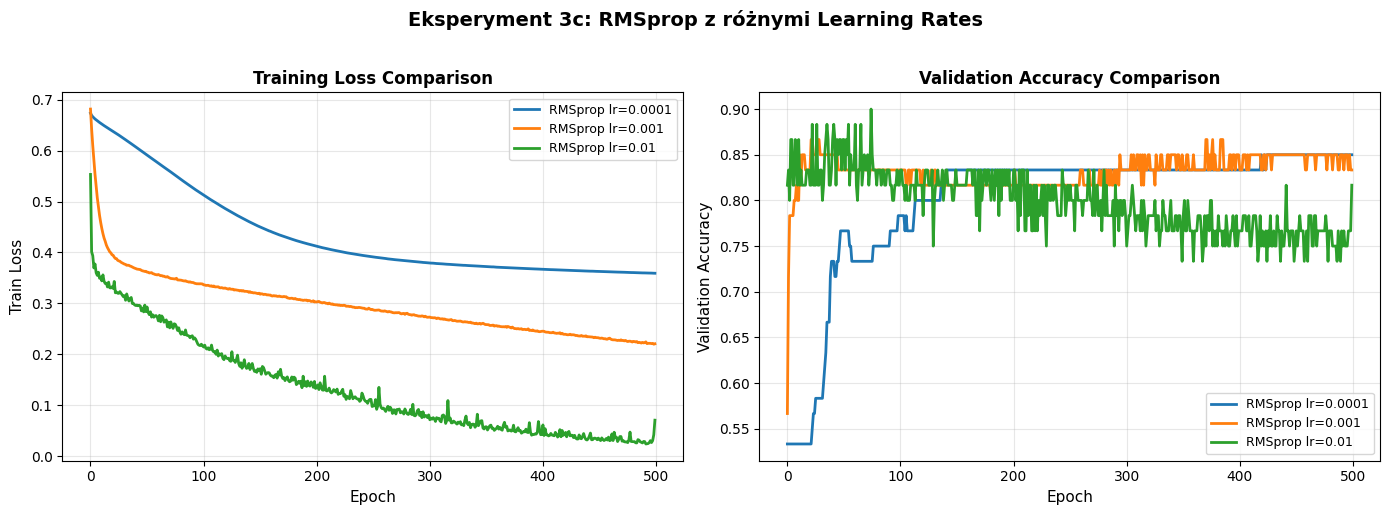


PODSUMOWANIE WYNIKÓW
Konfiguracja                                Train Acc      Val Acc        Gap
------------------------------------------------------------------------------------------
RMSprop lr=0.0001                              0.8354       0.8500    -0.0146
RMSprop lr=0.001                               0.9198       0.8333     0.0865
RMSprop lr=0.01                                0.9705       0.8167     0.1538
RMSprop lr=0.1                                 0.4599       0.4667    -0.0068


In [105]:
# RMSprop
print("\n--- RMSprop ---")
results_rmsprop_lr = []
results_rmsprop_lr_plot = []
rmsprop_lrs = [0.0001, 0.001, 0.01, 0.1]

for lr in rmsprop_lrs:
    history, model = test_configuration(
        optimizer_name='RMSprop',
        lr=lr,
        batch_size=32,
        epochs=500
    )
    

    results_rmsprop_lr.append({
        'label': f"RMSprop lr={lr}",
        'history': history
    })

    if lr != 0.1:
        results_rmsprop_lr_plot.append({
            'label': f"RMSprop lr={lr}",
            'history': history
        })

plot_comparison(results_rmsprop_lr_plot, 
                "Eksperyment 3c: RMSprop z różnymi Learning Rates")
print_summary_table(results_rmsprop_lr)

## Adam

### Cel:

Sprawdzić, jak **learning rate** wpływa na proces uczenia i końcową skuteczność sieci neuronowej przy użyciu optymalizatora Adam.

### Ustawienia:

* Learning rates: `[0.0001, 0.001, 0.01, 0.1, 0.5]`
* Liczba epok: `500`
* Stałe parametry: `hidden_dim = 16`, `batch_size = 32`
* Optimizer: `Adam`


### Wnioski:

* **lr=0.0001**

  * Uczenie powolne, ale stabilne.
  * Train i Val accuracy są praktycznie równe (gap ~0%) → brak overfittingu.

* **lr=0.001**

  * Bardzo dobre wyniki, stabilne uczenie.
  * Train acc ~89%, Val acc ~85%, gap ~4.5%.
  * Uczenie szybsze niż przy lr=0.0001, brak silnego overfittingu.

* **lr=0.01**

  * Silny **overfitting**: Train acc prawie 100%, Val acc spada do 76%, gap ~23%.
  * Train loss spada niemal do 0, ale generalizacja znacznie pogarsza się.

* **lr=0.1**

  * Model nadal uczy się bardzo szybko (Train acc ~96%), ale Val loss eksploduje w późniejszych epokach.
  * Gap ~13%, co wskazuje na overfitting.

* **lr=0.5**

  * Uczenie niestabilne, Train acc spada do ~77%, Val acc ~83%, gap ujemny (-5.7%).
  * Duże kroki Adam powodują chaotyczne zmiany wag, brak stabilnej konwergencji.

### Ogólny wniosek:

* Adam jest **bardziej odporny na większe learning rates** niż RMSProp czy SGD, ale nadal **zbyt duże lr (>0.01)** prowadzi do overfittingu lub niestabilnego uczenia.
* Najlepsze rezultaty osiąga się przy **lr=0.001**, zapewniając dobrą generalizację i szybkie, stabilne uczenie.
* Zbyt mały lr (0.0001) powoduje powolny trening, a zbyt duży (0.1–0.5) prowadzi do eksplodujących wag lub niestabilności.



--- Adam ---



Config: Adam, lr=0.0001, batch_size=32
Epoch 1/500 | Train loss=0.7105 acc=0.4599 | Val loss=0.7061 acc=0.4667
Epoch 100/500 | Train loss=0.5601 acc=0.8101 | Val loss=0.5449 acc=0.8000
Epoch 200/500 | Train loss=0.4403 acc=0.8397 | Val loss=0.4158 acc=0.8167
Epoch 300/500 | Train loss=0.3923 acc=0.8354 | Val loss=0.3658 acc=0.8500
Epoch 400/500 | Train loss=0.3729 acc=0.8354 | Val loss=0.3469 acc=0.8500
Epoch 500/500 | Train loss=0.3619 acc=0.8439 | Val loss=0.3379 acc=0.8500

Config: Adam, lr=0.001, batch_size=32
Epoch 1/500 | Train loss=0.6692 acc=0.6582 | Val loss=0.6646 acc=0.7500
Epoch 100/500 | Train loss=0.3352 acc=0.8650 | Val loss=0.3195 acc=0.8167
Epoch 200/500 | Train loss=0.3119 acc=0.8734 | Val loss=0.3032 acc=0.8333
Epoch 300/500 | Train loss=0.2881 acc=0.8861 | Val loss=0.3066 acc=0.8333
Epoch 400/500 | Train loss=0.2676 acc=0.8987 | Val loss=0.3141 acc=0.8167
Epoch 500/500 | Train loss=0.2463 acc=0.9072 | Val loss=0.3241 acc=0.8333

Config: Adam, lr=0.01, batch_size=3

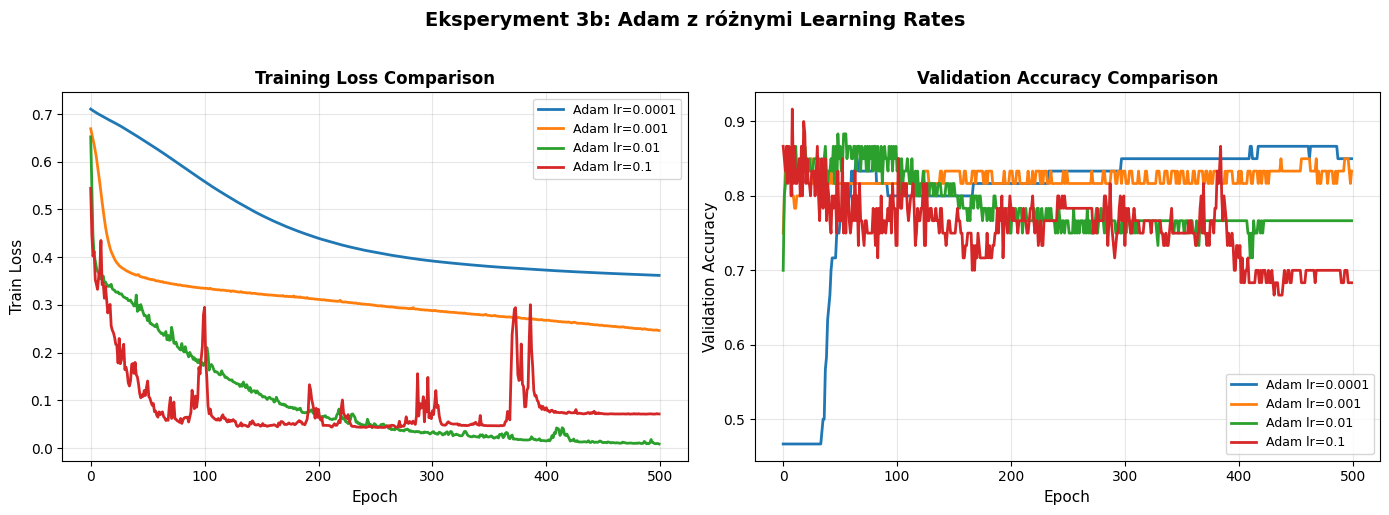


PODSUMOWANIE WYNIKÓW
Konfiguracja                                Train Acc      Val Acc        Gap
------------------------------------------------------------------------------------------
Adam lr=0.0001                                 0.8439       0.8500    -0.0061
Adam lr=0.001                                  0.9072       0.8333     0.0738
Adam lr=0.01                                   1.0000       0.7667     0.2333
Adam lr=0.1                                    0.9620       0.6833     0.2787


In [103]:

# Adam
print("\n--- Adam ---")
results_adam_lr = []
adam_lrs = [0.0001, 0.001, 0.01, 0.1]

for lr in adam_lrs:
    history, model = test_configuration(
        optimizer_name='Adam',
        lr=lr,
        batch_size=32,
        epochs=500
    )
    
    results_adam_lr.append({
        'label': f"Adam lr={lr}",
        'history': history
    })

plot_comparison(results_adam_lr, 
                "Eksperyment 3b: Adam z różnymi Learning Rates")
print_summary_table(results_adam_lr)


# Porównanie optymalizatorów dla różnych learning rates

Poniżej przedstawione są 4 wykresy porównujące training loss dla wszystkich optymalizatorów przy różnych wartościach learning rate.

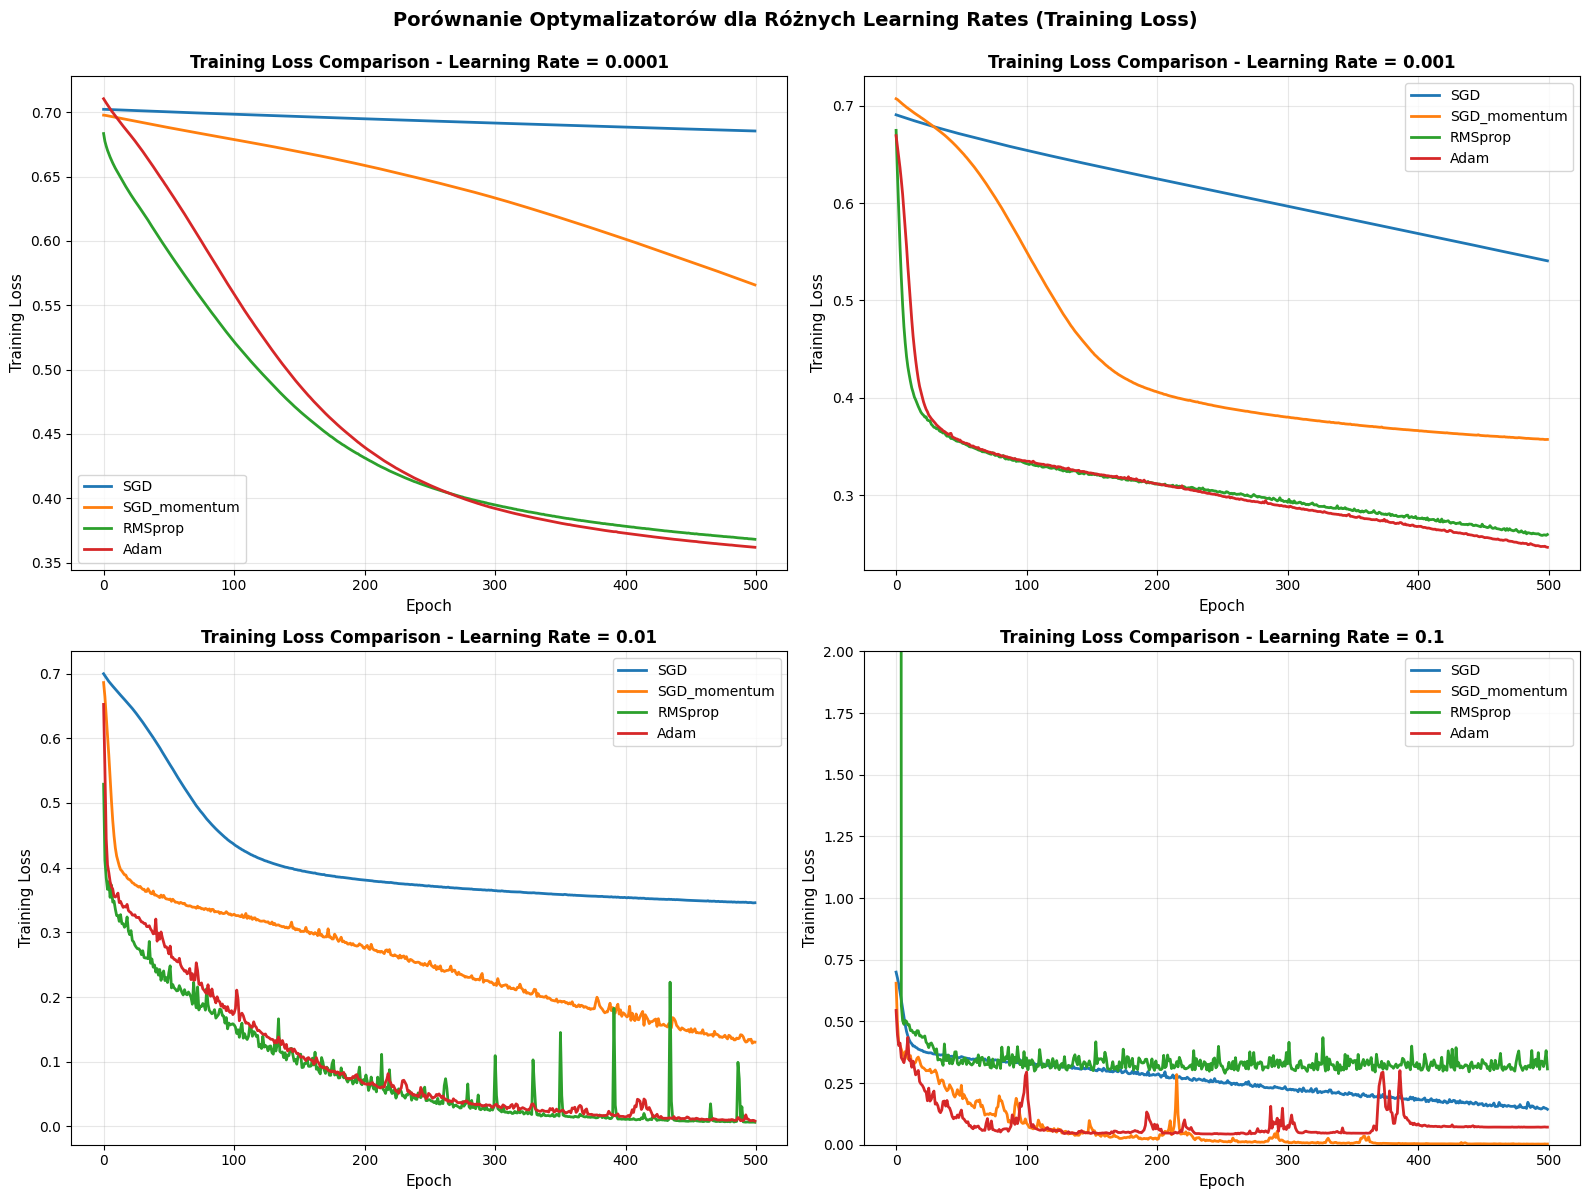

In [104]:
# Przygotowanie danych do porównania optymalizatorów dla różnych learning rates
# Zbieramy wszystkie wyniki w jeden słownik

optimizer_lr_comparison = {
    'SGD': results_sgd_lr,
    'SGD_momentum': results_sgd_mom_lr,
    'RMSprop': results_rmsprop_lr,
    'Adam': results_adam_lr
}

# Zdefiniujemy learning rates do porównania (wspólne dla większości optymalizatorów)
common_lrs = [0.0001, 0.001, 0.01, 0.1]

# Dla każdego learning rate stworzymy osobny wykres
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, lr in enumerate(common_lrs):
    ax = axes[idx]
    
    for opt_name, results_list in optimizer_lr_comparison.items():
        for result in results_list:
            # Wyciągnij lr z labela (np. "SGD lr=0.001")
            if f"lr={lr}" in result['label']:
                ax.plot(result['history']['train_loss'], 
                       label=opt_name, 
                       linewidth=2)
                break
    
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Training Loss', fontsize=11)
    ax.set_title(f'Training Loss Comparison - Learning Rate = {lr}', 
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Ustaw limit osi Y dla lepszej widoczności 
    if lr == 0.1:
        ax.set_ylim([0, 2])  # Dla lr=0.1 mogą być większe wartości

plt.suptitle('Porównanie Optymalizatorów dla Różnych Learning Rates (Training Loss)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()